Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [116]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [117]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,7)
X, y = load_digits(return_X_y=True)

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

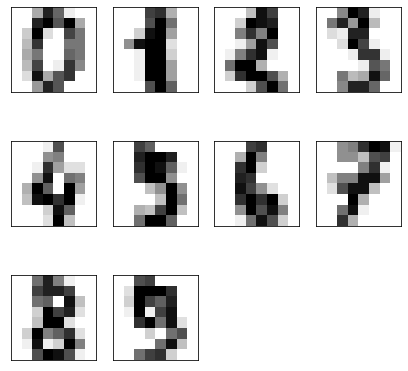

In [118]:
def plot_digits(data):
    plt.gray()
    for x in np.arange(0, 10):
        ax = plt.subplot(3, 4, x + 1)
        plt.imshow((16-data[x]).reshape(8, 8), interpolation='none')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

plot_digits(X)

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [119]:
from sklearn.cluster import AgglomerativeClustering, KMeans

agglo = AgglomerativeClustering(n_clusters=10)
agglo_clusters = agglo.fit_predict(X)
print(f'AgglomerativeClustering results: {agglo_clusters}')

kMeans = KMeans(n_clusters=10, n_init=100)
kMeans_clusters = kMeans.fit_predict(X)
print(f'KMeans results: {kMeans_clusters}')


AgglomerativeClustering results: [7 9 4 ... 4 1 4]
KMeans results: [0 4 4 ... 4 1 1]


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

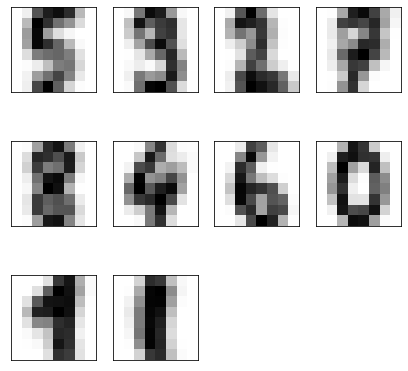

In [120]:
# AgglomerativeClustering
plot_digits([np.mean(X[agglo_clusters == x], axis=0).reshape(8,8) for x in np.arange(0, 10)])

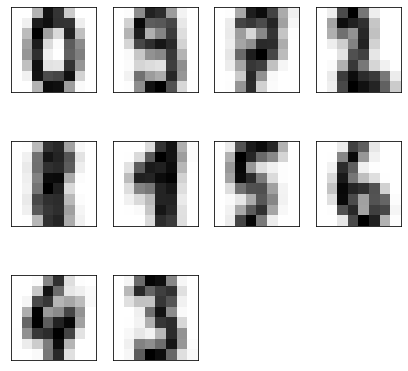

In [121]:
# KMeans
plot_digits([np.mean(X[kMeans_clusters == x], axis=0).reshape(8,8) for x in np.arange(0, 10)])

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [122]:
from sklearn.metrics import silhouette_score
import pandas as pd
import seaborn as sns

df = pd.DataFrame(columns=['k', 'val', 'type'])
for k in np.arange(2, 21):
    clusters = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    df = df.append({'k': k, 'val': silhouette_score(X, clusters), 'type': 'AgglomerativeClustering'}, ignore_index=True)

    clusters = KMeans(n_clusters=k, n_init=100).fit_predict(X)
    df = df.append({'k': k, 'val': silhouette_score(X, clusters), 'type': 'KMeans'}, ignore_index=True)

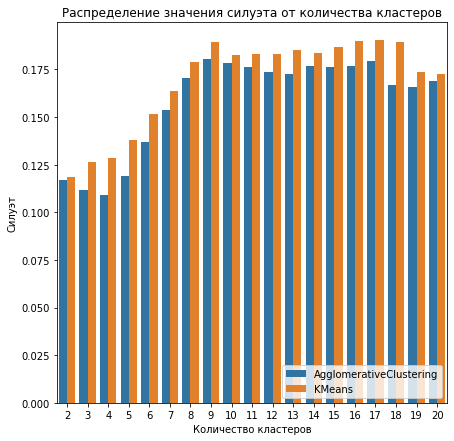

Максимальный силуэт (0.1901638816516167) для KMeans при K=[17]
Максимальный силуэт (0.18061975703867697) для AgglomerativeClustering при K=[9]


In [123]:
sns.barplot(x='k', y='val', hue='type', data=df)
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэт')
plt.legend(loc='lower right')
plt.title('Распределение значения силуэта от количества кластеров')
plt.show()

for t in ['KMeans', 'AgglomerativeClustering']:
    print(f'Максимальный силуэт ({df[df["type"] == t]["val"].max()}) для {t} при K={df[df["val"] == df[df["type"] == t]["val"].max()]["k"].values}')

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [124]:
from sklearn.metrics import v_measure_score

df = pd.DataFrame(columns=['k', 'val', 'type'])
for k in np.arange(2, 21):
    clusters = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    df = df.append({'k': k, 'val': v_measure_score(y, clusters), 'type': 'AgglomerativeClustering'}, ignore_index=True)

    clusters = KMeans(n_clusters=k, n_init=100).fit_predict(X)
    df = df.append({'k': k, 'val': v_measure_score(y, clusters), 'type': 'KMeans'}, ignore_index=True)

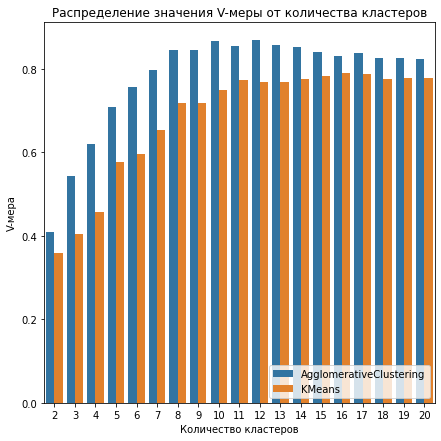

Максимальная V-мера (0.7909146687038227) для KMeans при K=[16]
Максимальная V-мера (0.86854875186737) для AgglomerativeClustering при K=[12]


In [125]:
sns.barplot(x='k', y='val', hue='type', data=df)
plt.xlabel('Количество кластеров')
plt.ylabel('V-мера')
plt.legend(loc='lower right')
plt.title('Распределение значения V-меры от количества кластеров')
plt.show()

for t in ['KMeans', 'AgglomerativeClustering']:
    print(f'Максимальная V-мера ({df[df["type"] == t]["val"].max()}) для {t} при K={df[df["val"] == df[df["type"] == t]["val"].max()]["k"].values}')

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [126]:
from sklearn.decomposition import TruncatedSVD

for dim in [2, 5, 10, 20]:
    X_dimmed = TruncatedSVD(n_components=dim).fit_transform(X)
    clusters = AgglomerativeClustering(n_clusters=10).fit_predict(X_dimmed)
    print(f'AgglomerativeClustering: Силуэт для dim={dim}: {silhouette_score(X_dimmed, clusters)}')
    print(f'AgglomerativeClustering: V-мера для dim={dim}: {v_measure_score(y, clusters)}')

    clusters = KMeans(n_clusters=10).fit_predict(X_dimmed)
    print(f'KMeans: Силуэт для dim={dim}: {silhouette_score(X_dimmed, clusters)}')
    print(f'KMeans: V-мера для dim={dim}: {v_measure_score(y, clusters)}')

AgglomerativeClustering: Силуэт для dim=2: 0.280817085708472
AgglomerativeClustering: V-мера для dim=2: 0.3337189903948925
KMeans: Силуэт для dim=2: 0.3480032741139783
KMeans: V-мера для dim=2: 0.35125353932655273
AgglomerativeClustering: Силуэт для dim=5: 0.2727412811079301
AgglomerativeClustering: V-мера для dim=5: 0.6756036446423491
KMeans: Силуэт для dim=5: 0.31257914438144824
KMeans: V-мера для dim=5: 0.6351431850310998
AgglomerativeClustering: Силуэт для dim=10: 0.25071353477628017
AgglomerativeClustering: V-мера для dim=10: 0.8259753348813222
KMeans: Силуэт для dim=10: 0.2634794585681051
KMeans: V-мера для dim=10: 0.7241257747374726
AgglomerativeClustering: Силуэт для dim=20: 0.19810017725521475
AgglomerativeClustering: V-мера для dim=20: 0.8290876351736165
KMeans: Силуэт для dim=20: 0.21268309228556145
KMeans: V-мера для dim=20: 0.7429530261065973


**Вывод**: Силуэт лучше на любой сниженной размерности. V-мера - хуже.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

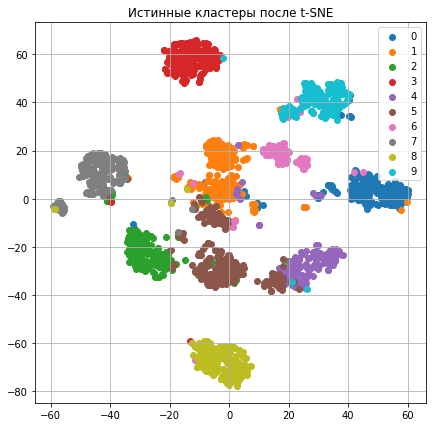

In [127]:
from sklearn.manifold import TSNE

X_dimmed = TSNE(n_components=2).fit_transform(X)
for g in np.unique(clusters):
    idx = np.where(clusters == g)
    plt.scatter(X_dimmed[idx, 0], X_dimmed[idx, 1], label=g)
plt.title('Истинные кластеры после t-SNE')
plt.legend()
plt.grid()
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [134]:
agglo_clusters = AgglomerativeClustering(n_clusters=10).fit_predict(X_dimmed)
print(f'AgglomerativeClustering для dim=2: силуэт={silhouette_score(X_dimmed, agglo_clusters)} V-мера={v_measure_score(y, agglo_clusters)}')

kMeans_clusters = KMeans(n_clusters=10, n_init=100).fit_predict(X_dimmed)
print(f'KMeans для dim=2: силуэт={silhouette_score(X_dimmed, kMeans_clusters)} V-мера={v_measure_score(y, kMeans_clusters)}')

AgglomerativeClustering для dim=2: силуэт=0.6285719275474548 V-мера=0.9004591980288357
KMeans для dim=2: силуэт=0.632868766784668 V-мера=0.9104077645990833


**Вывод**:  Удалось получить силуэт и V-меру лучше исходных

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

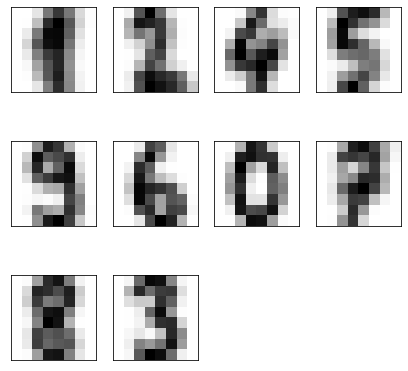

In [132]:
plot_digits([np.mean(X[kMeans_clusters == x], axis=0).reshape(8,8) for x in np.arange(0, 10)])

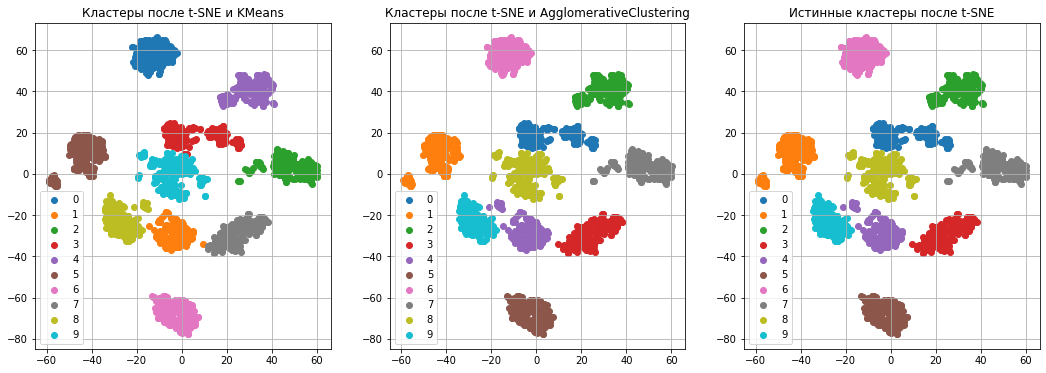

In [142]:
plt.rcParams["figure.figsize"] = (18,6)
ax = plt.subplot(1, 3, 1)
for g in np.unique(kMeans_clusters):
    idx = np.where(kMeans_clusters == g)
    ax.scatter(X_dimmed[idx, 0], X_dimmed[idx, 1], label=g)

ax.set_title('Кластеры после t-SNE и KMeans')
ax.grid()
ax.legend()
    
ax = plt.subplot(1, 3, 2)
for g in np.unique(agglo_clusters):
    idx = np.where(agglo_clusters == g)
    ax.scatter(X_dimmed[idx, 0], X_dimmed[idx, 1], label=g)
ax.set_title('Кластеры после t-SNE и AgglomerativeClustering')
ax.grid()
ax.legend()
    
ax = plt.subplot(1, 3, 3)
for g in np.unique(clusters):
    idx = np.where(clusters == g)
    ax.scatter(X_dimmed[idx, 0], X_dimmed[idx, 1], label=g)
ax.set_title('Истинные кластеры после t-SNE')
ax.legend()
ax.grid()

plt.show()

**Вывод**: Некоторые цифры очень похожи на правду, на scatter видно более строгое разделение кластеров.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

**Выводы**
1. Из проведенных экспериментов следует, что при использовании метода $K$ средних получается больший силуэт, а у иерархической кластеризации - большая $V$-мера (при прочих равных условиях и без снижения размерности). После снижения размерности кластеры после иерархической кластеризации более осмысленные.
1. Снижение размерности признакового пространства крайне положительно сказывается на качестве кластеризации. Известен феномен, что при больших значениях размерности пространства отношение расстояний между самыми близкими и самыми далекими точками стремится к 1. Как следствие, определение отношения к кластеру становится более затруднительным. Уменьшение размерности приводит расстояния и основанные на них критерии оценки качества в работоспособное состояние.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [143]:
from sklearn.datasets import fetch_openml
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

In [149]:
from sklearn.cluster import MiniBatchKMeans

# Попробуем кластеризовать в лоб
mnist_clusters = MiniBatchKMeans(n_clusters=10).fit_predict(X_mnist)
print(f'MiniBatchKMeans для MNIST: силуэт={silhouette_score(X_mnist, mnist_clusters)} V-мера={v_measure_score(y_mnist, mnist_clusters)}')

MiniBatchKMeans для MNIST: силуэт=0.0636628047766065 V-мера=0.45327697650893534


In [151]:
# Теперь снизим размерность до 2
X_mnist_dimmed = TSNE(n_components=2).fit_transform(X_mnist)

In [154]:
# И еще раз кластеризовать
mnist_dimmed_clusters = MiniBatchKMeans(n_clusters=10).fit_predict(X_mnist_dimmed)
print(f'MiniBatchKMeans для MNIST: силуэт={silhouette_score(X_mnist_dimmed, mnist_dimmed_clusters)} V-мера={v_measure_score(y_mnist, mnist_dimmed_clusters)}')

MiniBatchKMeans для MNIST: силуэт=0.36759284138679504 V-мера=0.7411715743860684


In [157]:
# Увеличим максимальное количество итераций
mnist_dimmed_clusters = MiniBatchKMeans(n_clusters=10, max_iter=1000).fit_predict(X_mnist_dimmed)
print(f'MiniBatchKMeans(max_iter=1000) для MNIST: силуэт={silhouette_score(X_mnist_dimmed, mnist_dimmed_clusters)} V-мера={v_measure_score(y_mnist, mnist_dimmed_clusters)}')

MiniBatchKMeans(max_iter=1000) для MNIST: силуэт=0.36290356516838074 V-мера=0.6931593562511633


In [159]:
# Попробуем перебрать количество кластеров
for k in [5, 7, 15, 20]:
    mnist_dimmed_clusters = MiniBatchKMeans(n_clusters=k).fit_predict(X_mnist_dimmed)
    print(f'MiniBatchKMeans(K={k}) для MNIST: силуэт={silhouette_score(X_mnist_dimmed, mnist_dimmed_clusters)} V-мера={v_measure_score(y_mnist, mnist_dimmed_clusters)}')

MiniBatchKMeans(K=5) для MNIST: силуэт=0.33995184302330017 V-мера=0.5615206918428004
MiniBatchKMeans(K=7) для MNIST: силуэт=0.37647736072540283 V-мера=0.6887555379254564
MiniBatchKMeans(K=15) для MNIST: силуэт=0.3778752088546753 V-мера=0.7283256912556504
MiniBatchKMeans(K=20) для MNIST: силуэт=0.38529014587402344 V-мера=0.7389328805467593


In [160]:
# Ну и попробуем пространство размерности 3
X_mnist_dimmed_3 = TSNE(n_components=3).fit_transform(X_mnist)

In [161]:
# Кластеризуем
mnist_dimmed_3_clusters = MiniBatchKMeans(n_clusters=10).fit_predict(X_mnist_dimmed_3)
print(f'MiniBatchKMeans для MNIST (размерность 3): силуэт={silhouette_score(X_mnist_dimmed_3, mnist_dimmed_3_clusters)} V-мера={v_measure_score(y_mnist, mnist_dimmed_3_clusters)}')

MiniBatchKMeans для MNIST (размерность 3): силуэт=0.3386494517326355 V-мера=0.7353568748193781


**Вывод**: Наилучшие значения силуэта и $V$-меры достигаются при снижении размерности пространства до 2 признаков и количестве кластеров равном количеству истинных кластеров